### Cosc2671 Assignment 2 Group 15 


In [2]:
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
import nltk
import praw
import datetime as dt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# Initialize tools
tokenizer = TweetTokenizer()
tokenizer = TweetTokenizer(preserve_case=False)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [4]:
def preprocess_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    #Remove non-alphabetic characters but keep @, #, and apostrophe
    text = re.sub(r'[^a-zA-Z@\s#\']', '', text)
    #Tokenize
    tokens = tokenizer.tokenize(text)
    #Remove stopwords and short tokens; lemmatize
    cleaned = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    return cleaned

In [5]:
#Reddit API credentials
clientid = "FgY4iejqu83Q9QpgNMX9dQ"
clientsecret = "eeSZYZUjfMIAQ5qcULOc9SSYOHghFQ"
password = "1357900jkx"
username = "Traditional-Shine402"
useragents = 'client for SNAM2024'
reddit = praw.Reddit(client_id=clientid, client_secret=clientsecret,password=password,
                           username=username,user_agent=useragents)


#Keywords and Subreddits
keywords = [
    "moon landing fake", 
    "moon landing hoax", 
    "fake moon landing", 
    "did we land on the moon", 
    "moon landing conspiracy", 
    "moon landing was staged", 
    "apollo mission fake", 
    "moon landing faked", 
    "moon hoax", 
    "apollo hoax", 
    "moon conspiracy", 
    "moon landing lies", 
    "nasa faked moon landing"]

subreddits = ["conspiracy", "moonlandingfake"]


In [6]:
#Data collection
posts = []

for subreddit in subreddits:
    for keyword in keywords:
        for submission in reddit.subreddit(subreddit).search(keyword, limit=10000):
            posts.append({
                'subreddit': subreddit,
                'title': submission.title.lower(),
                'text': submission.selftext.lower(),
                'author': str(submission.author),
                'score': submission.score,
                'created_utc': dt.datetime.fromtimestamp(submission.created_utc),
                'id': submission.id,
                'num_comments': submission.num_comments
            })

posts_df = pd.DataFrame(posts)
print(f"Fetched {len(posts_df)} posts.")
# Fetch comments
comments_data = []

for post_id in posts_df['id']:
    if len(comments_data) > 25000:
        break
    submission = reddit.submission(id=post_id)
    submission.comments.replace_more(limit=0)
    for comment in submission.comments.list():
        comments_data.append({
            'post_id': post_id,
            'comment_body': comment.body.lower(),
            'author': str(comment.author),
            'score': comment.score,
            'created_utc': dt.datetime.fromtimestamp(comment.created_utc)
        })

comments_df = pd.DataFrame(comments_data)
comments_df['cleaned_tokens'] = comments_df['comment_body'].astype(str).apply(preprocess_text)
comments_df.to_csv("reddit_comments.csv", index=False)
print(f"Fetched {len(comments_df)} comments.")


Fetched 2853 posts.
Fetched 25058 comments.


In [7]:
posts_df['all_text'] = posts_df['title'] + " " + posts_df['text']
posts_df['cleaned_tokens'] = posts_df['all_text'].astype(str).apply(preprocess_text)
posts_df.to_csv("reddit_posts.csv", index=False)

In [8]:
posts_df

,subreddit,title,text,author,score,created_utc,id,num_comments,all_text,cleaned_tokens
0,conspiracy,did we ever land on the moon…?,,Own_Teacher3433,739,2024-08-23 22:28:45,1ezbh2v,759,did we ever land on the moon…?,"[ever, land, moon]"
1,conspiracy,can you tell me why you think the moon landing...,i come in peace! i am a about to start my phd ...,Ms_Photon,862,2023-03-12 01:48:43,11olzpd,1374,can you tell me why you think the moon landing...,"[tell, think, moon, landing, fake, might, conv..."
2,conspiracy,"if the moon landing was fake, why the enemies ...",,TimmyOTule,194,2024-09-27 22:26:50,1fqmhry,527,"if the moon landing was fake, why the enemies ...","[moon, landing, fake, enemy, revealed]"
3,conspiracy,why do people get so defensive when the 1969 m...,whenever a moon landing conspiracy is posted t...,Majin_Vegeta_,252,2024-01-03 10:27:29,18x3uai,449,why do people get so defensive when the 1969 m...,"[people, get, defensive, moon, landing, questi..."
4,conspiracy,if the moon landing was faked how have other c...,"in my limited understanding of space travel, w...",5afari,387,2022-07-13 22:57:31,vy2lws,525,if the moon landing was faked how have other c...,"[moon, landing, faked, country, debunked, yet,..."
...,...,...,...,...,...,...,...,...,...,...
2848,moonlandingfake,why i no longer believe the apollo moon landin...,,HelicopterJesus,4,2021-10-27 04:31:21,qgbkci,1,why i no longer believe the apollo moon landin...,"[longer, believe, apollo, moon, landing, faked..."
2849,moonlandingfake,here's the truth,moon landings were faked on the moon.💀,Sea-Mark-7504,12,2023-03-04 04:55:36,11h8s9e,5,here's the truth moon landings were faked on t...,"[here's, truth, moon, landing, faked, moon]"
2850,moonlandingfake,bruh,i've gotten 50 new types of brain cancer from ...,YesterdayDirect8401,20,2022-11-26 00:36:44,z4dkp6,6,bruh i've gotten 50 new types of brain cancer ...,"[bruh, gotten, new, type, brain, cancer, came,..."
2851,moonlandingfake,is it me or has the internet become the most e...,i used to use it to win all kinds of arguments...,ElectronicPresenc,13,2022-09-21 16:45:45,xjxct3,7,is it me or has the internet become the most e...,"[internet, become, efficient, disinformation, ..."


In [9]:
comments_df

,post_id,comment_body,author,score,created_utc,cleaned_tokens
0,1ezbh2v,###[meta] sticky comment\n\n[rule 2](https://w...,AutoModerator,1,2024-08-23 22:28:47,"[###meta, sticky, comment, rule, apply, replyi..."
1,1ezbh2v,i once asked a.i how to get sugar out of a gas...,dinahmoon,806,2024-08-24 01:15:41,"[asked, get, sugar, gas, tank, told, use, stra..."
2,1ezbh2v,everyone loves ai when it gives you the answer...,Binarydemons,161,2024-08-24 03:49:59,"[everyone, love, give, answer, want, hear]"
3,1ezbh2v,wow that ai has such an unbiased sounding name,before686entenz,641,2024-08-23 23:18:37,"[wow, unbiased, sounding, name]"
4,1ezbh2v,"i don't know, but china confirmed their probes...",AccordingWarning9534,324,2024-08-24 01:16:11,"[know, china, confirmed, probe, moon, rover, s..."
...,...,...,...,...,...,...
25053,vn4c3l,[removed],None,2,2022-06-30 07:12:15,[removed]
25054,vn4c3l,>no such thing for apollo photographs and vide...,MindshockPod,2,2022-07-01 02:57:57,"[thing, apollo, photograph, video, except, lit..."
25055,vn4c3l,so you confirm that you are a worthless intern...,very_curious_agent,1,2022-06-30 08:47:13,"[confirm, worthless, internet, shitter, thank]"
25056,vn4c3l,> literally tons of debunkings\n\nand those al...,Quicklythoughtofname,2,2022-07-01 03:11:25,"[literally, ton, debunking, refuted, nauseum, ..."


### Start code from here!

In [10]:
posts_df = pd.read_csv("reddit_posts.csv")
comments_df = pd.read_csv("reddit_comments.csv")

In [11]:
print(posts_df.isnull().sum())

subreddit           0
title               0
text              918
author              0
score               0
created_utc         0
id                  0
num_comments        0
all_text            0
cleaned_tokens      0
dtype: int64


In [12]:
import ast
# Convert strings that look like lists into real lists
posts_df['cleaned_tokens'] = posts_df['cleaned_tokens'].apply(ast.literal_eval)
comments_df['cleaned_tokens'] = comments_df['cleaned_tokens'].apply(ast.literal_eval)
# Now flatten
all_post_tokens = [token for tokens in posts_df['cleaned_tokens'] for token in tokens]
all_comments_tokens = [token for tokens in comments_df['cleaned_tokens'] for token in tokens]

In [13]:
#Combine all tokens
all_tokens = all_post_tokens + all_comments_tokens

In [14]:
print("Total tokens: ", len(all_tokens))
unique_tokens = len(set(all_tokens))
print("Unique tokens: ", unique_tokens)

Total tokens:  1163381
Unique tokens:  36504


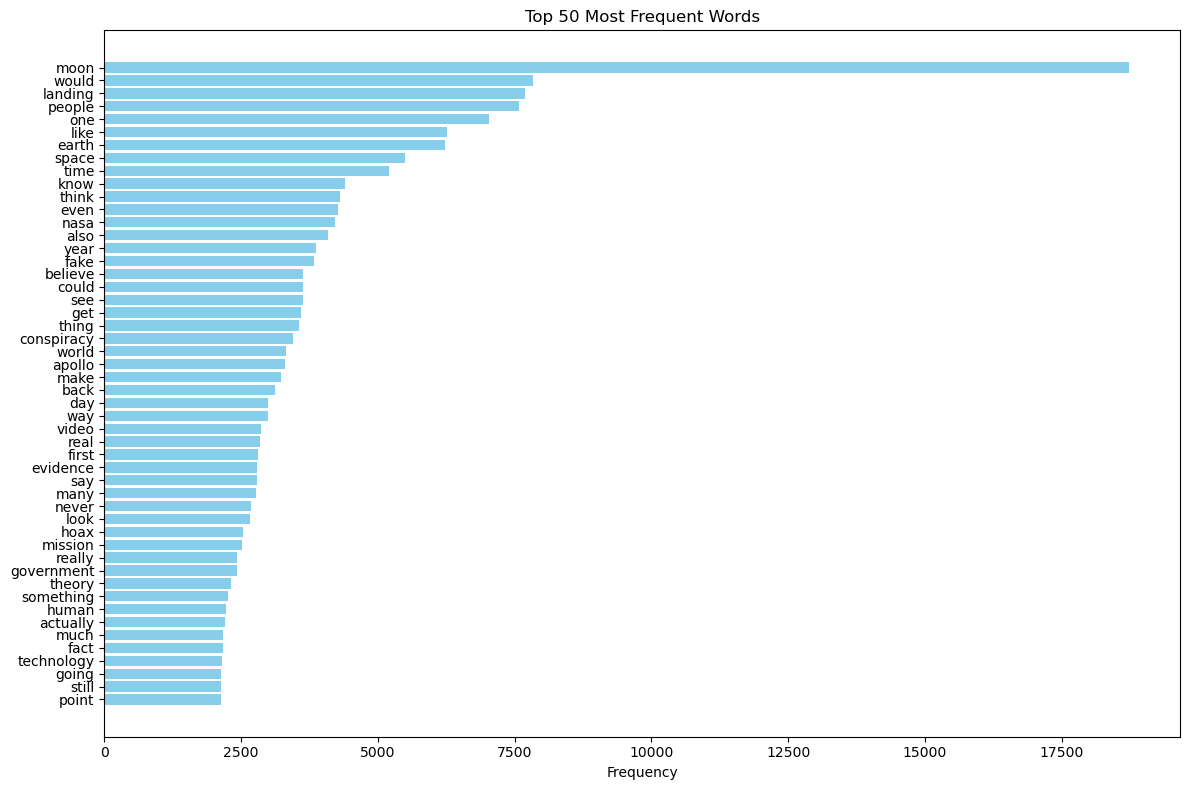

In [15]:
from collections import Counter

token_freq = Counter(all_tokens)
#Get the top 50 most common words
top_words = Counter(all_tokens).most_common(50)

#Separate the words and their counts
words, counts = zip(*top_words)

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(words[::-1], counts[::-1], color='skyblue')  # reverse to have highest on top
plt.xlabel("Frequency")
plt.title("Top 50 Most Frequent Words")
plt.tight_layout()
plt.show()

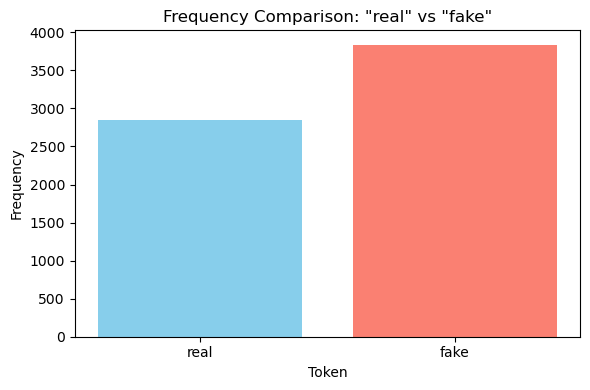

In [16]:
# Get frequencies (default to 0 if not found)
real_freq = Counter(all_tokens).get('real', 0)
fake_freq = Counter(all_tokens).get('fake', 0)

# Create bar chart
plt.figure(figsize=(6, 4))
plt.bar(['real', 'fake'], [real_freq, fake_freq], color=['skyblue', 'salmon'])
plt.title('Frequency Comparison: "real" vs "fake"')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


### Sentiment Analysis

In [17]:
#Rename posts tokens column
posts_df.rename(columns={'cleaned_tokens': 'cleaned_tokens_post'}, inplace=True)

#Rename comments tokens column if needed
comments_df.rename(columns={'cleaned_tokens': 'cleaned_tokens_comments'}, inplace=True)


In [18]:
#Create a dictionary to hold post_id
comment_token_map = {}

for i in range(len(comments_df)):
    post_id = comments_df.loc[i, 'post_id']
    tokens = comments_df.loc[i, 'cleaned_tokens_comments']
    
    if post_id not in comment_token_map:
        comment_token_map[post_id] = []
    
    comment_token_map[post_id].extend(tokens)

#Prepare a list to hold the final combined tokens
combined_data = []

for i in range(len(posts_df)):
    post_id = posts_df.loc[i, 'id']
    post_tokens = posts_df.loc[i, 'cleaned_tokens_post']
    comment_tokens = comment_token_map.get(post_id, [])
    subreddit = posts_df.loc[i,'subreddit']
    
    all_tokens = post_tokens + comment_tokens
    combined_data.append({'post_id': post_id, 'subreddit': subreddit, 'all_tokens': all_tokens})

combined_tokens_df = pd.DataFrame(combined_data)


In [19]:
combined_tokens_df

,post_id,subreddit,all_tokens
0,1ezbh2v,conspiracy,"[ever, land, moon, ###meta, sticky, comment, r..."
1,11olzpd,conspiracy,"[tell, think, moon, landing, fake, might, conv..."
2,1fqmhry,conspiracy,"[moon, landing, fake, enemy, revealed, ###meta..."
3,18x3uai,conspiracy,"[people, get, defensive, moon, landing, questi..."
4,vy2lws,conspiracy,"[moon, landing, faked, country, debunked, yet,..."
...,...,...,...
2848,qgbkci,moonlandingfake,"[longer, believe, apollo, moon, landing, faked..."
2849,11h8s9e,moonlandingfake,"[here's, truth, moon, landing, faked, moon]"
2850,z4dkp6,moonlandingfake,"[bruh, gotten, new, type, brain, cancer, came,..."
2851,xjxct3,moonlandingfake,"[internet, become, efficient, disinformation, ..."


In [20]:
sia = SentimentIntensityAnalyzer()

#get compound sentiment score tokens = tokens from reddit posts
def get_sentiment(tokens):
    text = ' '.join(tokens)
    sentiment = sia.polarity_scores(text)
    return sentiment['compound']

#Apply sentiment score function to the DataFrame
combined_tokens_df['sentiment'] = combined_tokens_df['all_tokens'].apply(get_sentiment)


In [21]:
combined_tokens_df

,post_id,subreddit,all_tokens,sentiment
0,1ezbh2v,conspiracy,"[ever, land, moon, ###meta, sticky, comment, r...",0.9997
1,11olzpd,conspiracy,"[tell, think, moon, landing, fake, might, conv...",0.9997
2,1fqmhry,conspiracy,"[moon, landing, fake, enemy, revealed, ###meta...",-0.8991
3,18x3uai,conspiracy,"[people, get, defensive, moon, landing, questi...",0.9956
4,vy2lws,conspiracy,"[moon, landing, faked, country, debunked, yet,...",-0.9801
...,...,...,...,...
2848,qgbkci,moonlandingfake,"[longer, believe, apollo, moon, landing, faked...",0.0000
2849,11h8s9e,moonlandingfake,"[here's, truth, moon, landing, faked, moon]",0.3182
2850,z4dkp6,moonlandingfake,"[bruh, gotten, new, type, brain, cancer, came,...",0.1280
2851,xjxct3,moonlandingfake,"[internet, become, efficient, disinformation, ...",-0.9438


In [22]:
#Group by subreddit
sentiment_by_subreddit = combined_tokens_df.groupby('subreddit')['sentiment'].mean().sort_values()


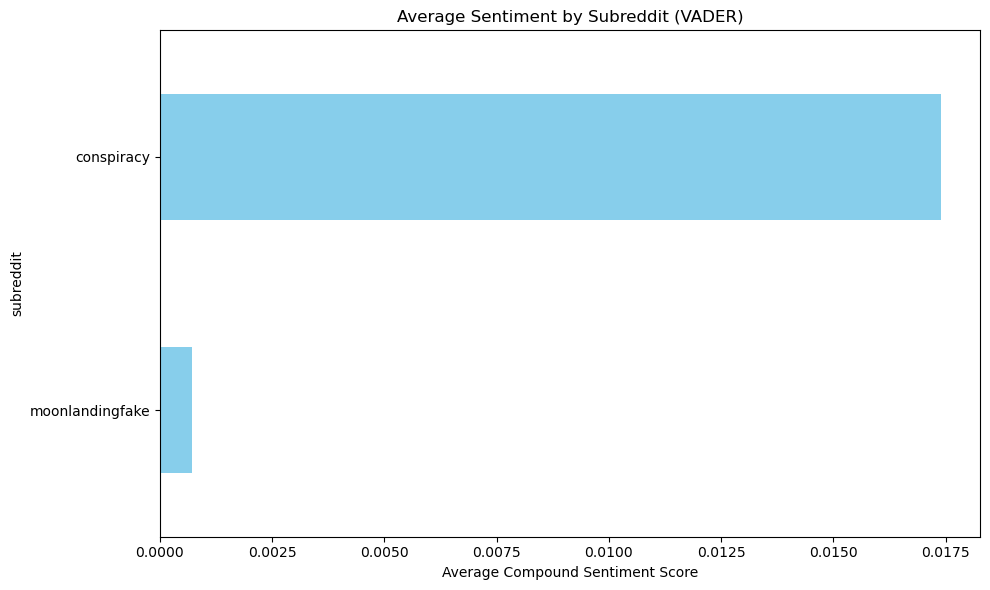

In [23]:
# Plotting
plt.figure(figsize=(10, 6))
sentiment_by_subreddit.plot(kind='barh', color='skyblue')
plt.xlabel('Average Compound Sentiment Score')
plt.title('Average Sentiment by Subreddit (VADER)')
plt.tight_layout()
plt.show()


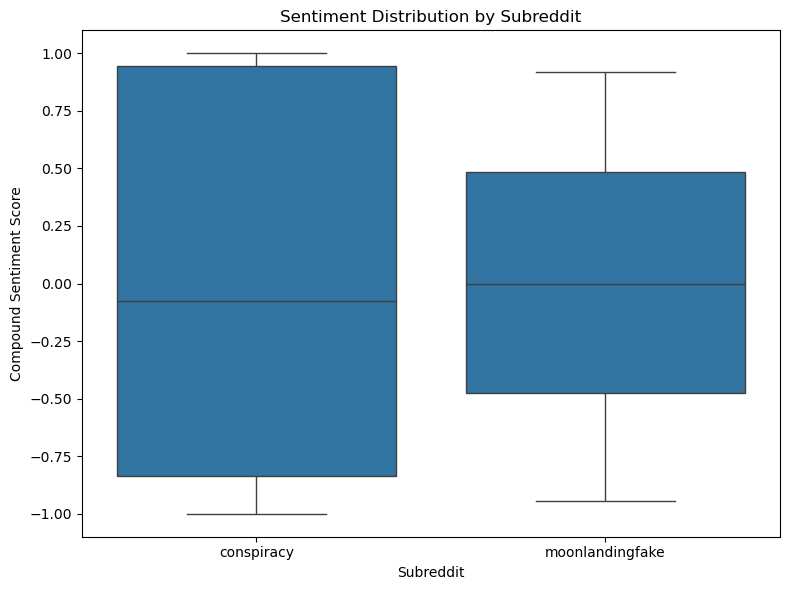

In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='subreddit', y='sentiment', data=combined_tokens_df)
plt.title('Sentiment Distribution by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Compound Sentiment Score')
plt.tight_layout()
plt.show()

### Topic Modelling

In [25]:
#Group by subreddit into a dictionary
grouped_tokens = (
    combined_tokens_df.groupby('subreddit')['all_tokens']
    .apply(lambda token_lists: [' '.join(tokens) for tokens in token_lists])
    .to_dict()
)

In [26]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import math

#Get the LDA topics

def get_lda_topics(docs, num_topics=5, num_words=15):
    vectorizer = CountVectorizer(max_df=0.85, min_df=1, stop_words='english')
    doc_term_matrix = vectorizer.fit_transform(docs)

    lda_model = LDA(n_components=num_topics, random_state=42)
    lda_model.fit(doc_term_matrix)

    feature_names = vectorizer.get_feature_names_out()
    
    topics = []
    for topic in lda_model.components_:
        top_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        topics.append(top_words)
    
    return lda_model, feature_names, topics

In [27]:
def display_wordcloud(lda_model, feature_names, topic_idx=0):
    topic = lda_model.components_[topic_idx]
    topic_words = {feature_names[i]: topic[i] for i in topic.argsort()[:-16:-1]}
    
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(topic_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()


 Subreddit: conspiracy


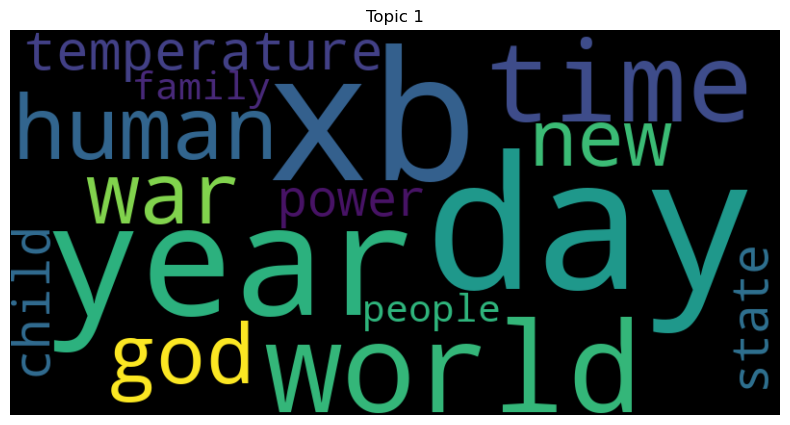

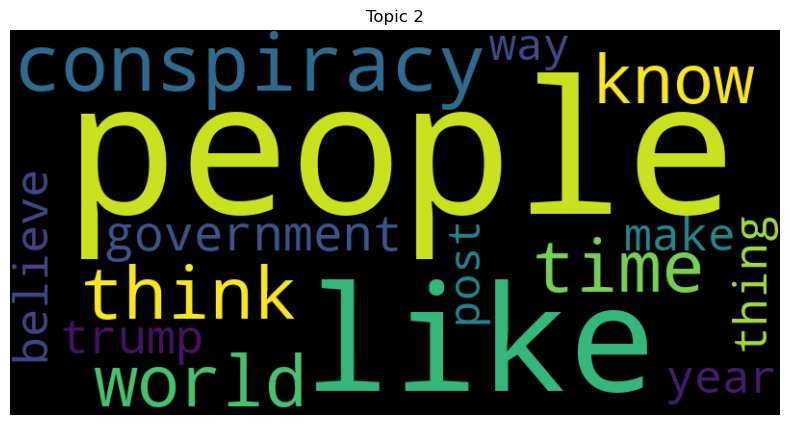

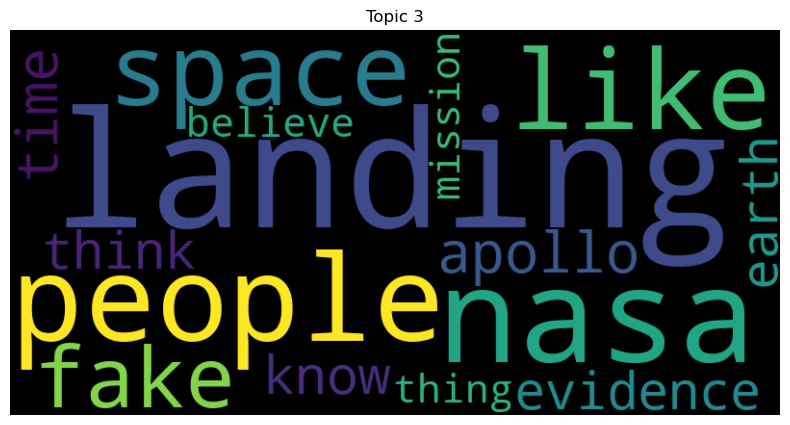

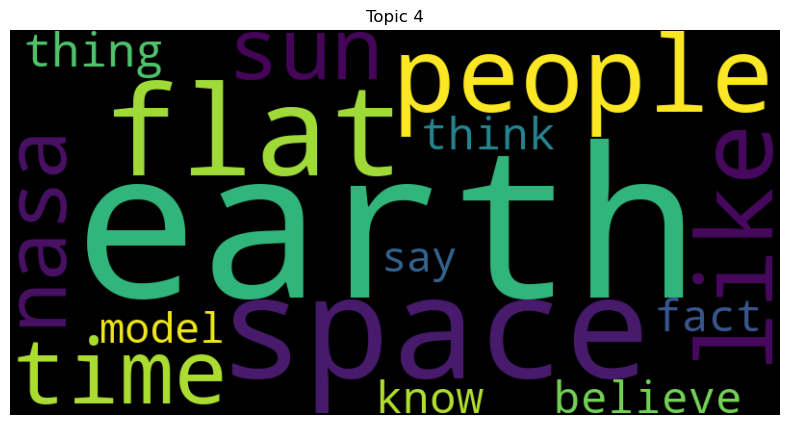

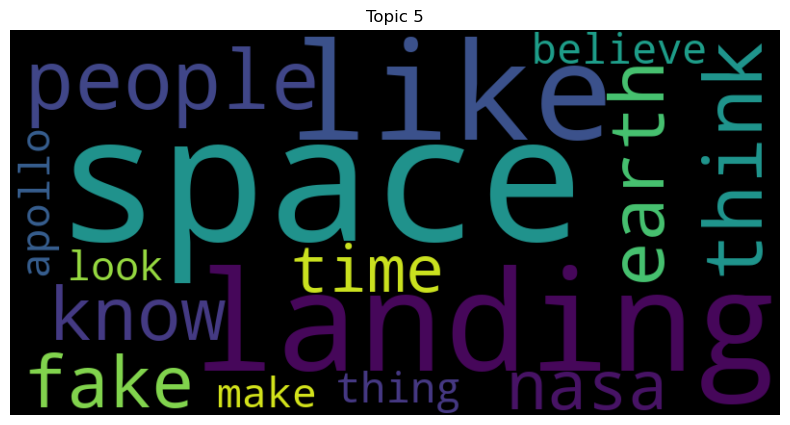


 Subreddit: moonlandingfake


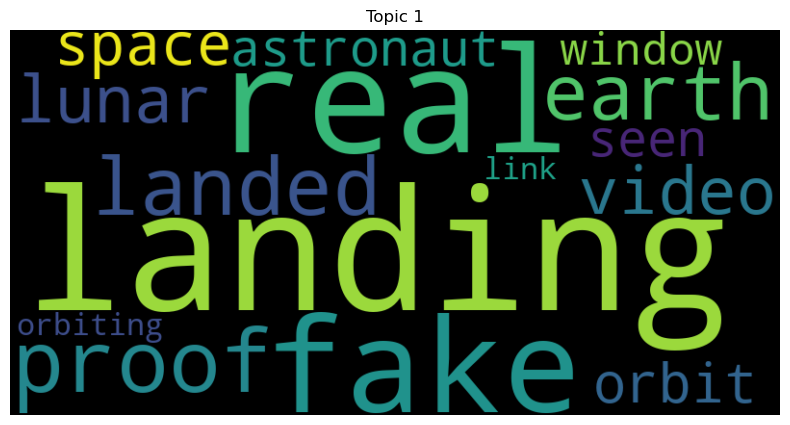

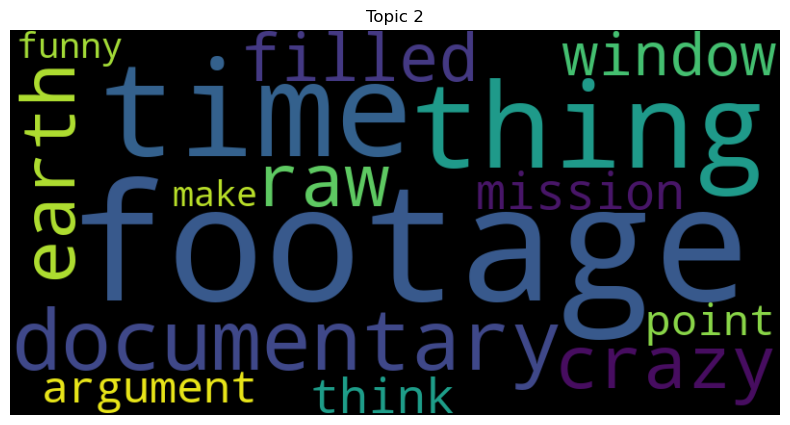

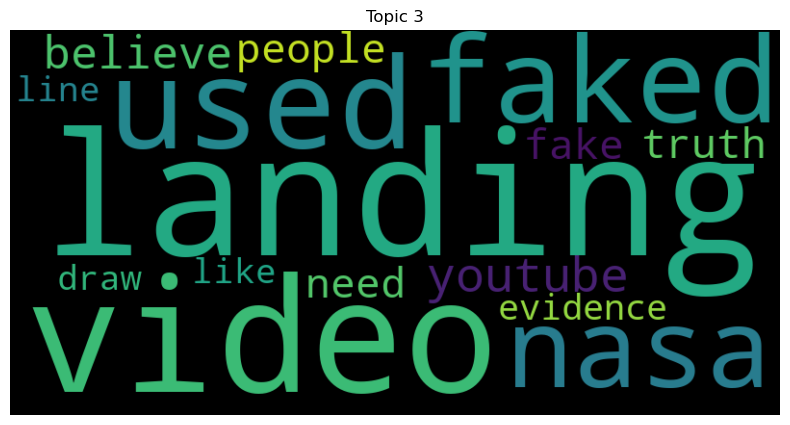

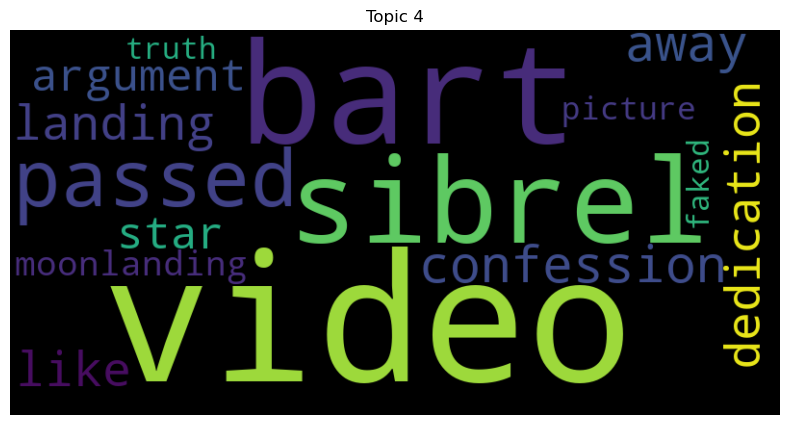

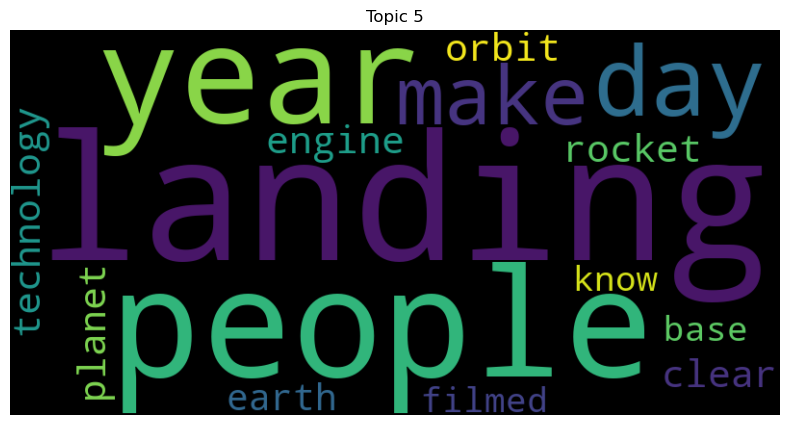

In [28]:
for subreddit, docs in grouped_tokens.items():
    if len(docs) > 1:
        print(f"\n Subreddit: {subreddit}")
        lda_model, feature_names, topics = get_lda_topics(docs, num_topics=5, num_words=15)
        for i, topic_words in enumerate(topics):
            display_wordcloud(lda_model, feature_names, topic_idx=i)